<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>


<center>
<h3 style="color:#888888;"> <i>--  Introduction à la méthode de Boltzmann sur Réseau  --</i> </h3>
<h1> TP n°4 </h1>
<h3> Modèles de collision Avancés </h3>

<h6><a href="mailto:simon.marie@lecnam.net">simon.marie@lecnam.net</a></h6>
</center>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib
import matplotlib.animation as animation
import matplotlib.patches as patches
from IPython import get_ipython
fs=20
plt.style.use('seaborn-dark')
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.rc('text', usetex=True)
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.usetex'] = False

<h1> Préambule </h1>

Le TP doit être rendu sous la forme d'un Notebook jupyter en respectant la nomenclature suivante:
<center>
<b>TP4_NOM1_NOM2.ipynb</b>
</center>

Tous les résultats, discussions, analyses, doivent donc être inclus dans le fichier.

<h1>Présentation du TP</h1>

On se propose dans ce TP de reprendre les simulations réalisées dans les TP2 et 3 et d'appliquer un modèle de collision avancé de type MRT ou régularisation (au choix). On utilisera dans ce TP le réseau de vitesse D2Q9.


Vous pouvez donc reprendre soit le TP2: *Ecoulement dans une cavité entrainée*, soit le TP3: *Ecoulement autour d'un cylindre* en reprenant également les mêmes conditions aux limites mais en remplacant la collision par un des deux modèles avancés présentés ci-dessous.


In [ ]:
ca=np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]]) #shéma D2Q9 donc 9 directions
w=[4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36] #racines des polynomes de Hermites (TP 0)
c0=1/np.sqrt(3) # facteur de normalisation des vitesses propres lorsque l'on conserve les moments jusqu'à l'ordre 2

<h2>Le modèle à temps de relaxation multiple MRT</h2>

Le principe du modèle MRT est de réaliser l'étape de collision dans l'espace des moments. Pour cela il faut donc définir 9 moments indépendants. La construction de ces moments fait l'objet de nombreux articles et ne sera pas détaillé ici. On donne ici la version classique qui utilise la matrice de passage suivante pour passer des distributions aux moments:

$$
\mathbf{M}=\left(
\begin{array}{ccccccccc}
1&1&1&1&1&1&1&1&1\\
-4&-1&-1&-1&-1&2&2&2&2\\
4&-2&-2&-2&-2&1&1&1&1\\
0&1&0&-1&0&1&-1&-1&1\\
0&-2&0&2&0&1&-1&-1&1\\
0&0&1&0&-1&1&1&-1&-1\\
0&0&-2&0&2&1&1&-1&-1\\
0&1&-1&1&-1&0&0&0&0\\
0&0&0&0&0&1&-1&1&-1\\
\end{array}
\right)
$$

Les moments sont donc obtenus à partir des distributions:

$$
\mathbf{m}=\mathbf{M}\mathbf{g}
$$

et la partie équilibre:

$$
\mathbf{m}^{eq}=\mathbf{M}\mathbf{g}^{eq}
$$

La collision devient alors:

$$
\displaystyle{g_{\alpha}^{coll} = g_{\alpha} - \mathbf{M}^{-1}\mathbf{S}[\mathbf{m}-\mathbf{m}^{eq}] }
$$

Où $\mathbf{S}$ est la matrice des temps de relaxation qui peuvent être fixés indépendemment pour chacun des moments. La littérature base le choix de ses temps de relaxation sur une optimisation de la stabilité et donne:

$$
\displaystyle{S=diag(0,1.05,1.1,0,1.25,0,1.25,1/\tau_g,1/\tau_g)}
$$


In [ ]:
M=np.array([[1,1,1,1,1,1,1,1,1],[-4,-1,-1,-1,-1,2,2,2,2],[4,-2,-2,-2,-2,1,1,1,1],
           [0,1,0,-1,0,1,-1,-1,1],[0,-2,0,2,0,1,-1,-1,1],[0,0,1,0,-1,1,1,-1,-1],
           [0,0,-2,0,2,1,1,-1,-1],[0,1,-1,1,-1,0,0,0,0],[0,0,0,0,0,1,-1,1,-1]]) # matrice M des moments
M=np.transpose(M)
# en prenant la transposée on peut faire les produits matriciel de manière correcte donc on préfère cette manipulation
# on calcul en avance la transposée pour gagner du temps car elle est constante durant la boucle

In [ ]:
taug=1 # on changera la valeur pour la boucle de calcul
S=np.diag([0,1.05,1.1,0,1.25,0,1.25,1/taug,1/taug])
# chaque moment à un temps de relaxation qui lui est propre.
# Cela nous permet de rendre le modèle plus robuste en introduisant indirectement un effet de dissipation

In [ ]:
def collision_MRT(gcoll,g,geq,M,S):
    m=np.dot(g,M)
    meq=np.dot(geq,M)
    Minv=np.linalg.inv(M)
    Seq=np.dot(m-meq,S) # on se sert du produit matriciel pour effectuer la multiplication, incorporée dans le modèle numpy
    gcoll[:,:,:]=g[:,:,:]-np.dot(Seq,Minv)[:,:,:]
    return gcoll

<h2>Le modèle régularisé</h2>

Le principe du modèle régularisé est de reconstruire la partie hors équilibre en utilisant une estimation à l'aide du tenseur de cisaillement $S_{ij}$ calculé à l'ordre 2 par différences finies:

$$      
\displaystyle{g_\alpha^{heq}=-\dfrac{\omega_\alpha \rho \tau_g \Delta t}{c_0^2}H_{ij}S_{ij}}
$$


**Attention** ici il y a bien sommation sur i et j: $H_{ij}S_{ij}=H_{11}S_{11}+H_{12}S_{12}+H_{21}S_{21}+H_{22}S_{22}$.

Avec:

$$
H_{ij}=c_{\alpha,i}c_{\alpha,j}-c_0^2 \delta_{ij}
$$

et

$$
\displaystyle{S_{ij}=\dfrac{1}{2}\left( \dfrac{\partial u_i}{\partial x_j}+\dfrac{\partial u_j}{\partial x_i} \right)}
$$

En remplacant $g$ par $g^{eq}+g^{heq}$, dans l'étape de collision BGK, la nouvelle collision devient:

$$
\displaystyle{g_{\alpha}^{coll} = g_{\alpha}^{eq}+ \left(1-\dfrac{1}{\tau_g}\right)g_{\alpha}^{heq}}
$$

**Note:** On pourra utiliser la fonction <a href="https://numpy.org/doc/stable/reference/generated/numpy.gradient.html">*gradient*</a> de numpy pour évaluer les composante de $S_{ij}$.

In [ ]:
def Sij(St,ux,uy):
    '''
    Calcul du tenseur de cisaillement

    u1=ux
    u2=uy
    x1=x
    x2=y
    '''
    duxdx,duxdy=np.gradient(ux,edge_order=2)
    duydx,duydy=np.gradient(uy,edge_order=2)
    St[:,:,0] = duxdx
    St[:,:,1] = 0.5 * (duxdy + duydx)
    St[:,:,2] = 0.5 * (duydx + duxdy)
    St[:,:,3] = duydy
    return St

In [ ]:
H2 = np.zeros((2,2,9))
for i in range(9):
        H2[0,0,i] = ca[i,0] * ca[i,0] - c0*c0*1
        H2[0,1,i] = ca[i,0] * ca[i,1] - c0*c0*0
        H2[1,0,i] = ca[i,1] * ca[i,0] - c0*c0*0
        H2[1,1,i] = ca[i,1] * ca[i,1] - c0*c0*1

In [ ]:
def hors_eq(gheq,rho,St,H2):
    '''
    Mise a jour de la partie hors equilibre
    '''
    for i in range(9):
        gheq[:,:,i] = (-w[i]*rho[:,:]*taug*deltat)/(c0**2)*(H2[0,0,i]*St[:,:,0] + H2[0,1,i]*St[:,:,1] + H2[1,0,i]*St[:,:,2] + H2[1,1,i]*St[:,:,3])
    return gheq
# on prend le delta t en unité réseau lattice et il vaut donc 1

In [ ]:
def init_heq(rho,ux,uy,H2):
    '''
    Initialisation de la partie hors eq
    '''
    St = np.zeros((nx,ny,4))
    Sij(St,ux,uy)
    gheq = np.zeros((nx,ny,9))
    gheq=hors_eq(gheq,rho,St,H2)
    return St,gheq

In [ ]:
def collision_regu(gcoll,geq,gheq,taug):
    '''
    Mise a jour de la collision régularisé
    '''
    gcoll[:,:,:]= geq[:,:,:]  + (1-1/taug) * gheq[:,:,:]
    return gcoll

<h1>Travail demandé</h1>

En reprenant les mêmes conditions initiales et les mêmes conditions aux limites que dans le TP2 ou 3, implémentez une des deux collisions avancées pour effectuer des calculs pour des plus grand nombre de Reynolds.

Comparez vos résultats à ceux obtenus pour la collision BGK.


<b style="color:#0055FA"> <h4>On reprend le TP3 pour tester le modèles de collision avancé MRT.</h4>

<b style="color:#0055FA"> On initialise et on redéfinit les fonctions.

In [ ]:
# Maillage/Domaine

R=5 # rayon du cylindre

Lx=40*R # taille du domaine en fonction de R
Ly=20*R

nx=70*R # paramètre de maille, en fonction de R
ny=40*R

x0,y0=int(8*R),int(ny/2) # centre du cylindre

dx = R/nx # Taille de maille:

# Vitesse du son réelle à 293K:
c0_real=np.sqrt(1.4*287*293) #racine de gamma*R*T pour gaz parfaits

dt=dx*c0/c0_real # Pas de temps
deltat=1 # delta de temps en unité réseau
M0=0.3 # Mach

U0=M0*c0 # vitesse du fluide initiale
print(U0)

print('nb de mailles : '+str(nx*ny))

0.17320508075688776
nb de mailles : 70000


<b style="color:#0055FA"> On récupère les fonctions du TP précédent

In [ ]:
def init(M0,Re):

    # Initialisation du domaine
    rho,uy=np.ones((nx,ny)),np.zeros((nx,ny))
    ux=U0*np.ones((nx,ny)) # le fluide est initalement à la vitesse U0 selon l'axe x
    nu=U0*2*R/Re #augmenter Re veut dire diminuer la viscosité
    taug=0.5+3*nu # on se sert de la formule du cours
    print('Valeur de taug : '+str(taug)+' \n')

    # on doit mettre à l'équilibre la fonction geq car le fluide n'est pas au repos
    geq=np.zeros((nx,ny,9))
    geq=eq(rho,ux,uy,geq,c0,ca)
    return geq,rho,ux,uy,taug,U0,nu

def eq(rho,ux,uy,geq,c0,ca):
    # Mise à jour de geq
    for i in range (0,9):
        # ca[i,0] donne le vecteur vitesse associé selon les polynomes de Hermite
        # développement polynomial de la fonction d'équilibre pour une quadrature de guass à l'ordre 2
        geq[:,:,i] = rho[:,:]*w[i]*(1.+ (ca[i][0]*ux + ca[i][1]*uy) / (c0**2) + ( (  ca[i][0]*ux + ca[i][1]*uy )**2) / (2.*c0**4) - (ux**2 + uy**2) / (2.*c0**2) )
    return geq

def propagate(g,gcoll):

    # Etape de propagation, identique au TP précédent

    g[:,:,0]=gcoll[:,:,0] #[0,0]

    g[1:,:,1]=gcoll[0:-1,:,1] #[1,0]
    g[:,1:,2]=gcoll[:,0:-1,2] #[0,1]
    g[0:-1,:,3]=gcoll[1:,:,3]#[-1,0]
    g[:,0:-1,4]=gcoll[:,1:,4]#[0,-1]

    g[1:,1:,5]=gcoll[0:-1,0:-1,5]#[1,1]
    g[0:-1,1:,6]=gcoll[1:,0:-1,6]#[-1,1]
    g[0:-1,:-1,7]=gcoll[1:,1:,7]#[-1,-1]
    g[1:,0:-1,8]=gcoll[0:-1,1:,8]#[1,-1]

    return(g)

def macro(g,rho,ux,uy):

    # identique au TP précédent

    # calcul des variables macro
    rux,ruy,rho=np.zeros((nx,ny)),np.zeros((nx,ny)),np.zeros((nx,ny))
    for i in range (0,9):
        rho+=g[:,:,i]
        rux+=g[:,:,i]*ca[i,0]
        ruy+=g[:,:,i]*ca[i,1]
        #On est en quadrature d'ordre 3 pour la quadrature de Gauss, donc on a egalité des moments jusqu’à l’ordre 2 (modèle D2Q9)
    ux=rux/rho
    uy=ruy/rho

    return(rho,ux,uy)

def wall_noslip(gcoll,g,mask):
    # Paroi solide sur le cylindre: Bounce back avec frottement
    g[mask==1,0]=gcoll[mask==1,0]
    g[mask==1,1]=gcoll[mask==1,3]
    g[mask==1,2]=gcoll[mask==1,4]
    g[mask==1,3]=gcoll[mask==1,1]
    g[mask==1,4]=gcoll[mask==1,2]
    g[mask==1,5]=gcoll[mask==1,7]
    g[mask==1,6]=gcoll[mask==1,8]
    g[mask==1,7]=gcoll[mask==1,5]
    g[mask==1,8]=gcoll[mask==1,6]
    return(g)

def inflow(g,rho,ux,uy,M0,c0,ca,geq):

    # Conditions de vitesse au bord superieur
    ux[0,:]=M0/np.sqrt(3) # !! ici il faut utiliser le M0 que vous passez en entrée
    uy[0,:]=0

    # Macro: On impose ux et on en déduit rho_in:
    rho[0,:]=1/(1-ux[0,:])*(2*(g[0,:,6]+g[0,:,3]+g[0,:,7])+g[0,:,0]+g[0,:,2]+g[0,:,4])

    # Distributions: On impose les distributions inconnues avec le Bounce-Back hors equilibre

    #recalcul des équilibres pour rho_wall
    geq=eq(rho,ux,uy,geq,c0,ca) #recalcul des équilibres pour rho_inflow
    g[0,:,5]=g[0,:,7]+(geq[0,:,5]-geq[0,:,7])
    g[0,:,1]=g[0,:,3]+(geq[0,:,1]-geq[0,:,3])
    g[0,:,8]=g[0,:,6]+(geq[0,:,8]-geq[0,:,6])

    return(g,geq,ux,uy,rho)

def outflow(g,gcoll):
    # Conditions de gradient nul

    # Out
    g[-1,:,3]=gcoll[-2,:,3]
    g[-1,:,6]=gcoll[-2,:,6]
    g[-1,:,7]=gcoll[-2,:,7]
    # Top avec i=-1 et i-1=-2
    g[1:,-1,4]=gcoll[1:,-2,4]
    g[1:,-1,7]=gcoll[1:,-2,7]
    g[1:,-1,8]=gcoll[1:,-2,8]
    # Bottom pareil
    g[1:,0,2]=gcoll[1:,1,2]
    g[1:,0,5]=gcoll[1:,1,5]
    g[1:,0,6]=gcoll[1:,1,6]

    return(g)

# Marquage des conditions aux limites:
# Fluide: mask=0
# Solide: mask=1
# mask=-1 à l'intérieur du solide, on ne fait pas le calcul

mask=np.zeros((nx,ny));

# on vectorise la création de l'obstacle
def obstacle(mask,x0,y0,R):
    nx,ny=mask.shape
    mask[int(x0-R):int(x0+R),int(y0-R):int(y0+R)]=1

obstacle(mask,x0,y0,R)

---------
<h1>Pour le modèle MRT</h1>

<b style="color:#0055FA"> On fait le calcul du TP3 avec le modèle MRT

In [ ]:
# Nombre de Reynolds:
Re=300

# initialisation:
geq,rho,ux,uy,taug,U0,mu=init(M0,Re)

#### on initialise nos valeurs utiles pour le MRT ####
S=np.diag([0,1.05,1.1,0,1.25,0,1.25,1/taug,1/taug]) # matrice S qui contient les temps de relaxation

g,gcoll=geq.copy(),geq.copy()
nt=0
start=time.time()

nitération=1000 # nombre d'itération souhaité
skip=nitération-50 # permet d'afficher à partir d'un certain nombre de tours

while (nt<nitération):

    nt+=1

    # boucle de LBM
    gcoll=collision_MRT(gcoll,g,geq,M,S) #### étape de collision avancée MRT ####
    g=propagate(g,gcoll) # étape de propagation
    g=wall_noslip(g,g,mask) # condition limite de bord d'obstacle
    g=outflow(gcoll,g) # condition limite de sortie Neumann
    g,geq,ux,uy,rho=inflow(g,rho,ux,uy,M0,c0,ca,geq) # condition limite entrée
    rho,ux,uy=macro(g,rho,ux,uy) # calcul des grandeurs macro

    geq=eq(rho,ux,uy,geq,c0,ca)

tcal=time.time()-start
if tcal>60:
    print(str(nt)+" itérations en "+str(int(tcal//60))+"m"+ str(int(tcal%60))+"s: Performances: "+str((1e-6)*nt*nx*ny/tcal)+"  MLUPS")
else :
    print(str(nt)+" itérations en "+str(tcal)+"s: Performances: "+str((1e-6)*nt*nx*ny/tcal)+"  MLUPS")

Valeur de taug : 0.5173205080756887 

1000 itérations en 5m26s: Performances: 0.21460115949027242  MLUPS


<b style="color:#0055FA"> On affiche le résultat suivant :

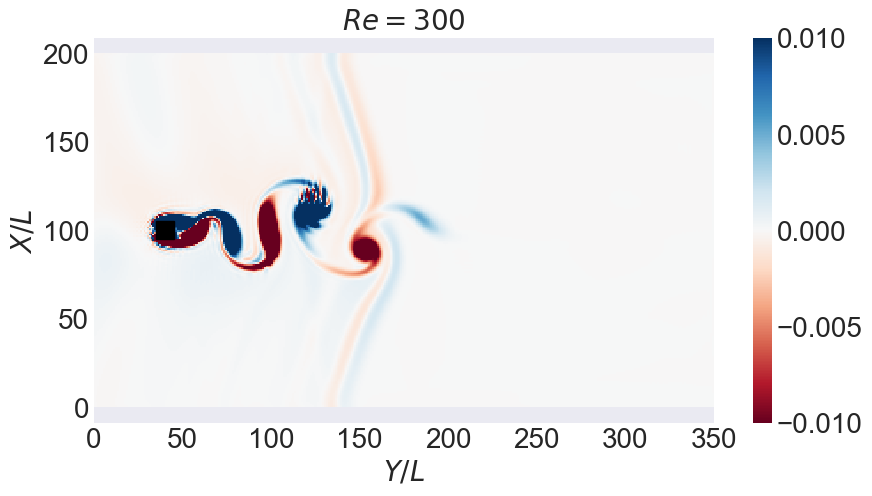

In [ ]:
dudx,dudy=np.gradient(ux,edge_order=2)
dvdx,dvdy=np.gradient(uy,edge_order=2)
vort=dudy-dvdx

fig=plt.figure(figsize=(10,5))
plt.pcolormesh(vort.T,cmap='RdBu',vmin=-0.01,vmax=0.01)
plt.colorbar()
plt.xlabel(r'$Y/L$',fontsize=fs)
plt.ylabel(r'$X/L$',fontsize=fs)
plt.title(r'$Re='+str(Re)+'$',fontsize=fs)
plt.axis('equal')
rect=patches.Rectangle((x0-R,y0-R),2*R,2*R, fill = True, color = "black",linewidth = 1)
plt.gca().add_patch(rect)

<b style="color:#0055FA"> Commentaires :
    
  Le temps d'execution est sensiblement plus long que le méthode BGK.
  On supprime les instabilités numériques sur le bord à gauche (côté inflow) et on augmente la qualité des tourbillons. En revanche, cela s'effectue avec du coût mémoire et une complexité plus élévée. En effet on effectue des opérations matricielles ce qui est plus lourd.

    

![343553550_1330064337852272_6808128829567613252_n.png](attachment:343553550_1330064337852272_6808128829567613252_n.png)

<b style="color:#0055FA"> Commentaires :
    
   Ci - dessus notre résultat pour la méthode collision BGK naturelle appliquée dans le TP 3 avec 1000 itérations et Re=300. On n'observe plus ces variations sur le bord gauche avec le modèle MRT. Le modèle BGK est moins robuste que le modèle MRT quant aux instabilités numériques car le modèle BGK n'est pas dissipatif. La moindre instabilité qui apparait dès qu'on se rapporche de taug=0.5 entraine une instabilité de la simulation et une divergence des valeurs.

-----------
## Pour le modèle Collisions régularisées

<b style="color:#0055FA"> On fait la même chose que précédemment avec l'autre modèle.

In [ ]:
# Nombre de Reynolds:
Re=300

# initialisation:
geq,rho,ux,uy,taug,U0,mu=init(M0,Re)

#### on mets à jour nos valeurs utiles pour la régularisation ####
St,gheq = init_heq(rho,ux,uy,H2)

g,gcoll=geq.copy(),geq.copy()
nt=0
start=time.time()

nitération=1000 # nombre d'itération souhaité
skip=nitération-50 # permet d'afficher à partir d'un certain nombre de tours

while (nt<nitération):

    nt+=1

    # boucle de LBM

    gcoll=collision_regu(gcoll,geq,gheq,taug) #### étape de collision avancée modèle régularisé ####

    g=propagate(g,gcoll) # étape de propagation
    g=wall_noslip(g,g,mask) # condition limite de bord d'obstacle
    g=outflow(gcoll,g) # condition limite de sortie Neumann
    g,geq,ux,uy,rho=inflow(g,rho,ux,uy,M0,c0,ca,geq) # condition limite entrée
    rho,ux,uy=macro(g,rho,ux,uy) # calcul des grandeurs macro

    geq=eq(rho,ux,uy,geq,c0,ca)

    St=Sij(St,ux,uy) #### mise a jour constante de hors équilibre ####
    gheq=hors_eq(gheq,rho,St,H2) #### mise a jour hors equilibre ####


tcal=time.time()-start
if tcal>60:
    print(str(nt)+" itérations en "+str(int(tcal//60))+"m"+ str(int(tcal%60))+"s: Performances: "+str((1e-6)*nt*nx*ny/tcal)+"  MLUPS")
else :
    print(str(nt)+" itérations en "+str(tcal)+"s: Performances: "+str((1e-6)*nt*nx*ny/tcal)+"  MLUPS")

Valeur de taug : 0.5173205080756887 

1000 itérations en 2m6s: Performances: 0.555274752589013  MLUPS


<b style="color:#0055FA"> On affiche le résultat suivant :

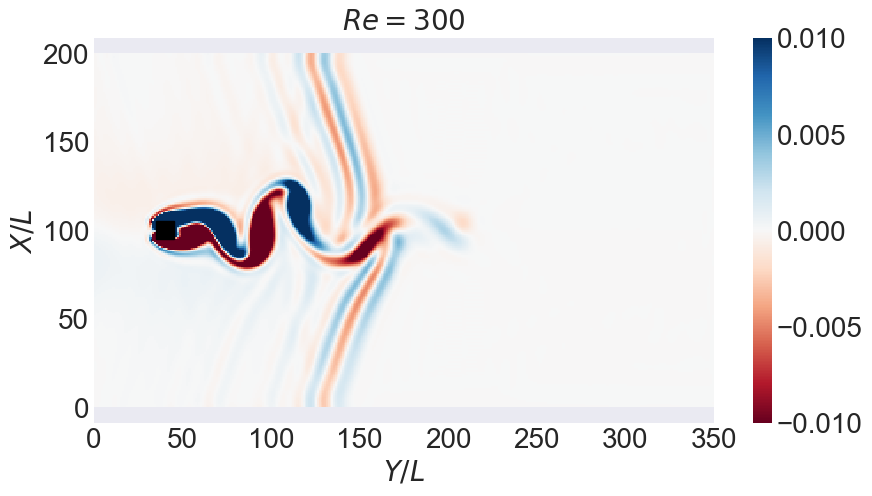

In [ ]:
dudx,dudy=np.gradient(ux,edge_order=2)
dvdx,dvdy=np.gradient(uy,edge_order=2)
vort=dudy-dvdx

fig=plt.figure(figsize=(10,5))
plt.pcolormesh(vort.T,cmap='RdBu',vmin=-0.01,vmax=0.01)
plt.colorbar()
plt.xlabel(r'$Y/L$',fontsize=fs)
plt.ylabel(r'$X/L$',fontsize=fs)
plt.title(r'$Re='+str(Re)+'$',fontsize=fs)
plt.axis('equal')
rect=patches.Rectangle((x0-R,y0-R),2*R,2*R, fill = True, color = "black",linewidth = 1)
plt.gca().add_patch(rect)

<b style="color:#0055FA"> Commentaires :
    

   On peut atteindre des hauts Reynolds avec cette méthode : on a atteinds Reynolds à a peu près 3000. On obtient quelque chose de moins net que la méthode BGK. Les tourbillons n'ont pas de petites queue aussi bien dessinées que dans les méthodes précédentes.
    
Ci dessous le résultat pour une simulation à Reynolds de 3000.
![3000.png](attachment:3000.png)
A Re=3000, le taug atteints une valeur de 0.501732. Elle se rapproche de 1/2. Pour cette valeur de taug le modèle BGK nous indiquait un overflow. Le modèle BGK n'est pas dissipatif et les instabilités se propagent dans toute la simulation. Le modèle régularisé pallie à ce défaut en ajoutant un peu de dissipation. Le modèle est donc plus stable, plus robuste face aux instabilités numériques.

# Conclusion

Présenter ici la synthèse de votre TP en décrivant les points importants et les principaux résultats.


<b style="color:#0055FA"> Notre réponse au TP :

Ce TP a été l’occasion pour nous de tester les méthodes de collision MRT et régularisée appliqué au problème du cylindre dans un jet uni-axial.
    
Ces méthodes nous ont permis de simuler des écoulements à haut Reynolds ce qui était auparavant impossible avec le modèle classique de collision BGK. Les deux nouvelles méthodes évitent l’apparition d’instabilités car elles permettent d’atténuer les non-linéarités dues à l’obstacle : réduction du bruit numérique. Cela nous permet donc de tester des écoulements à haut Reynolds très sensibles aux instabilités.
    
On obtient des erreurs de stack over-flow pour la méthode BGK une fois passé les 1000 de Reynolds car on a une amplification d’instabilités près du cylindre avec des vitesses infinies. La méthode MRT permet une meilleure précision et donne dans l’ensemble des tracés plus réalistes mais les temps de calculs sont très longs : 5min30 (pour notre exemple). La méthode régularisée donne de son coté des tracés plus grossiers qui doivent surement pouvoir être améliorés avec des ajustements. Si la méthode MRT ne permet pas d’aller au-delà du Reynolds 1500 la méthode avec régularisation atteint sans problème des Reynolds de l’ordre de 3000 avec l’observation d’un jet turbulent.
    
    
Suite aux quatre TP que nous avons effectués lors de ce cours, nous pensons avoir acquis une réelle compréhension de la méthode Lattice-Boltzman à la fois dans son approche physique mais aussi dans son implémentation numérique. Nous touchons aujourd’hui du doigts les enjeux d’une telle méthode de modélisation et pourquoi elle intéresse tant le monde industriel comme celui de la recherche.

<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:left;" href="http://www.cnam.fr//"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/commons/4/45/Logo_ENSTA_Paris.jpg"></a>
<center><a href="#top">Retour en haut de la page</a></center>